In [2]:
#IMPORTING ALL THE LIBRARIES FOR COLLECTION OF DATA AND RETRAINING THE MODEL
import cv2
import os
import time
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import random
import glob
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

Using TensorFlow backend.


In [ ]:
#SIMPLE CODE TO DRAW BOX AT THE REQUIRED AREA
def drawBox(img,bbox):
    x, y, w, h = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
    cv2.rectangle(img, (x, y), ((x + w), (y + h)), (255, 0, 255), 3, 3 )
    cv2.putText(img, "Tracking", (100, 75), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

myPath = 'data/images/train'
cameraNo = 0
cameraBrightness = 180
moduleVal = 10  # SAVE EVERY ITH FRAME TO AVOID REPETITION
minBlur = 500  # SMALLER VALUE MEANS MORE BLURRINESS PRESENT
grayImage = False # IMAGES SAVED COLORED OR GRAY
saveData = True   # SAVE DATA FLAG
showImage = True  # IMAGE DISPLAY FLAG
imgWidth = 224
imgHeight = 224
areamin=224*224
status=1

val= input('are you satisfied with detection (y/n)?')
#ASKING USER IF THE TWO LAYERS OF SECURITY WORKED WELL...IF THEY DIDN'T WE NEED TO MANUALLY ADD NEWER IMAGES OF THE OBJECT
#AS WELL AS COMPLETE THE TASK
tracker = cv2.TrackerMOSSE_create()
#PRE-BUILT TRACKER PROVIDED BY OPENCV
global countFolder
cap = cv2.VideoCapture(cameraNo)
cap.set(3, 640)
cap.set(4, 480)
cap.set(10,cameraBrightness)


count = 0
countSave =0


#def saveDataFunc():
    #global countFolder
    #countFolder = 0
    #while os.path.exists( myPath+ str(countFolder)):
        #countFolder += 1
    #os.makedirs(myPath + str(countFolder))

#if saveData:saveDataFunc()


if val is 'y':
    align()
elif val is 'n':
    class_index=input('Input: \n 0-Bowl \n 1-Mars Rover \n 2-Quadcopter \n 3-Wheel')
    #ASKING THE USER WHICH OBJECT IT IS
    success, frame = cap.read()
    bbox = cv2.selectROI("Tracking",frame, False)
    tracker.init(frame, bbox)
    
    
    while True:
        success, img = cap.read()
        success, bbox = tracker.update(img)
        #UPDATING TRACKER AT EACH FRAME
        x, y, w, h = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
        img_saved=img[x:x+2*w,y:y+2*h]
        #img1 = cv2.resize(img_saved,(imgWidth,imgHeight))
        #img1= tf.image.resize(img_saved,[224,224])
        #img2=tf.reshape(img1,[1,224,224,3])
        #img_saved=img2
        #if grayImage:img_saved = cv2.cvtColor(img_saved,cv2.COLOR_BGR2GRAY)
        #if saveData:
        #blur = cv2.Laplacian(img_saved, cv2.CV_64F).var()
        #if count % moduleVal ==0 and blur > minBlur:
        #if 4*w*h>areamin:
        
        if success:
            status=1
        else:
            status=0
        
        if status is 1:
            #SAVING THE IMAGE FOR TRAINIGNG THE MODEL AGAIN IF STATUS OF SUCCESS IS 1 AS IN IF SUCCESSFUL
            nowTime = time.time()
            cv2.imwrite(myPath+'/'+class_index+'/'+'img'+str(countSave)+"_"+"_"+str(nowTime)+".png", img)
            countSave+=1
        #count += 1
        
        if success:
            drawBox(img,bbox)
            status=1
        else:
            cv2.putText(img, "Lost", (100, 75), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            status=0
        
            
        cv2.imshow("Tracking", img)
        if cv2.waitKey(1) & 0xff == ord('q'):
            break

are you satisfied with detection (y/n)?n
Input: 
 0-Bowl 
 1-Mars Rover 
 2-Quadcopter 
 3-Wheel0


In [10]:
train_path='data/images/train'
valid_path='data/images/validation'

Total: 0


In [13]:
for c in random.sample(glob.glob('train/'+class_index+'/img*'),20):
    shutil.move(c,'validation/'+class_index)

ValueError: Sample larger than population

In [12]:
train_batches=ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['0','1','2','3'], batch_size=10)
valid_batches=ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['0','1','2','3'], batch_size=10)

Found 107 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


(10, 224, 224, 3) 



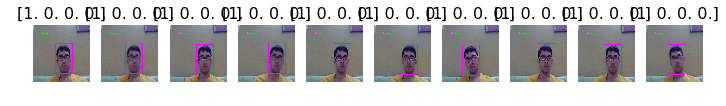

In [4]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        

imgs, labels = next(train_batches)
plots(imgs, titles=labels)
print(imgs.shape,'\n')

In [ ]:
batch_size_val=50
steps_per_epoch_val=2000
epochs_val=30
imageDimensions=(32,32,3)
#CALLING MODEL
from tensorflow.keras.models import load_model
model= load_model('models/CNN for RTOA.h5')

In [ ]:
model.summary()
history=model.fit_generator(train_batches, steps_per_epoch=30, validation_data=valid_batches, validation_steps=4, epochs=10, verbose=1)
#bhai steps per epoch number of images me 10 divide krke likhna hoga but count nhi ho paa rhe

In [ ]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [ ]:
#INCASE OF NO MODEL WE ADD A MODEL OR REPLACE IT
import os.path
if os.path.isfile('/content/drive/MyDrive/models/CNN for RTOA.h5') is False:
    model.save('/content/drive/MyDrive/models/CNN for RTOA.h5')
else:
    os.remove('/content/drive/MyDrive/models/CNN for RTOA.h5')
    model.save('/content/drive/MyDrive/models/CNN for RTOA_updated.h5')
    